In [1]:
%matplotlib inline

import os, sys
sys.path.append("/home/matthew/lscsoft/.virtualenvs/lalapps_knope_O2/lib/python2.7/site-packages")

import numpy as np
from scotchcorner import scotchcorner as sc
import lalapps.pulsarpputils as pppu

import subprocess as sp
import collections
import itertools
import json
from scipy import stats

In [4]:
postfileH1 = 'posterior_samples_J0109-0550A_H1.hdf'
postfileL1 = 'posterior_samples_J0109-0550A_L1.hdf'
postfileJoint = 'posterior_samples_J0109-0550A_H1L1.hdf' # to be added

# create figure
ps = collections.OrderedDict()
ps['H0'] = r'$h_0$'
ps['COSIOTA'] = r'$\cos{\iota}$'
ps['PHI0'] = r'$\phi_0$ (rad)'
ps['PSI'] = r'$\psi$ (rad)'
ps['F0'] = r'$\Delta f_0$ (Hz)'
ps['F1'] = r'$\Delta \dot{f}$ (Hz/s)'
ps['RA'] = r'$\Delta \alpha$ (rad)'
ps['DEC'] = r'$\Delta \delta$ (rad)'

truths = []
hetvals = [0., 0., 0., 0., 117.38320005, -3.8349e-11, pppu.ra_to_rad('01:09:44.3254290335'), pppu.dec_to_rad('-05:50:47.2999482561')]
injvals = [5.0357e-25, 0.19111, 0.87315, 0.72712, 117.3832, -3.8345e-11, pppu.ra_to_rad('01:09:44.3254290335'), pppu.dec_to_rad('-05:50:47.2999482561')]

for v in zip(injvals, hetvals):
    truths.append(v[0]-v[1])

H1samps = []
L1samps = []
Jointsamps = []
pH1, zH1, nH1 = pppu.pulsar_nest_to_posterior(postfileH1)
pL1, zL1, nL1 = pppu.pulsar_nest_to_posterior(postfileL1)
pJ, zJ, nJ = pppu.pulsar_nest_to_posterior(postfileJoint)
for i, p in enumerate(ps):
    H1samps.append(pH1[p].samples-hetvals[i])
    L1samps.append(pL1[p].samples-hetvals[i])
    Jointsamps.append(pJ[p].samples-hetvals[i])

H1samps = np.array(H1samps).squeeze().T
L1samps = np.array(L1samps).squeeze().T
Jointsamps = np.array(Jointsamps).squeeze().T

Read columns ['COSIOTA', 'DEC', 'F0', 'F1', 'H0', 'PHI0', 'PSI', 'RA', 'deltalogL', 'deltaloglH1', 'logL', 'logPrior', 'logw', 'C22', 'CGW', 'F2', 'F0_FIXED', 'HVECTORY', 'C21', 'HVECTORX', 'I31', 'F3', 'PHI0SCALAR', 'PHI0TENSOR', 'PEPOCH', 'PMRA', 'HPLUS', 'PHI22', 'THETA', 'HSCALARL', 'POSEPOCH', 'DIST', 'I21', 'PSITENSOR', 'IOTA', 'HSCALARB', 'PHI0VECTOR', 'F3_FIXED', 'HCROSS', 'COSTHETA', 'PMDEC', 'PX', 'PHI21', 'FREQNUM', 'Q22', 'df', 'PSIVECTOR', 'F1_FIXED', 'F2_FIXED', 'PSISCALAR', 'LAMBDA']
Read columns ['COSIOTA', 'DEC', 'F0', 'F1', 'H0', 'PHI0', 'PSI', 'RA', 'deltalogL', 'deltaloglL1', 'logL', 'logPrior', 'logw', 'C22', 'CGW', 'F2', 'F0_FIXED', 'HVECTORY', 'C21', 'HVECTORX', 'I31', 'F3', 'PHI0SCALAR', 'PHI0TENSOR', 'PEPOCH', 'PMRA', 'HPLUS', 'PHI22', 'THETA', 'HSCALARL', 'POSEPOCH', 'DIST', 'I21', 'PSITENSOR', 'IOTA', 'HSCALARB', 'PHI0VECTOR', 'F3_FIXED', 'HCROSS', 'COSTHETA', 'PMDEC', 'PX', 'PHI21', 'FREQNUM', 'Q22', 'df', 'PSIVECTOR', 'F1_FIXED', 'F2_FIXED', 'PSISCALAR', 'L

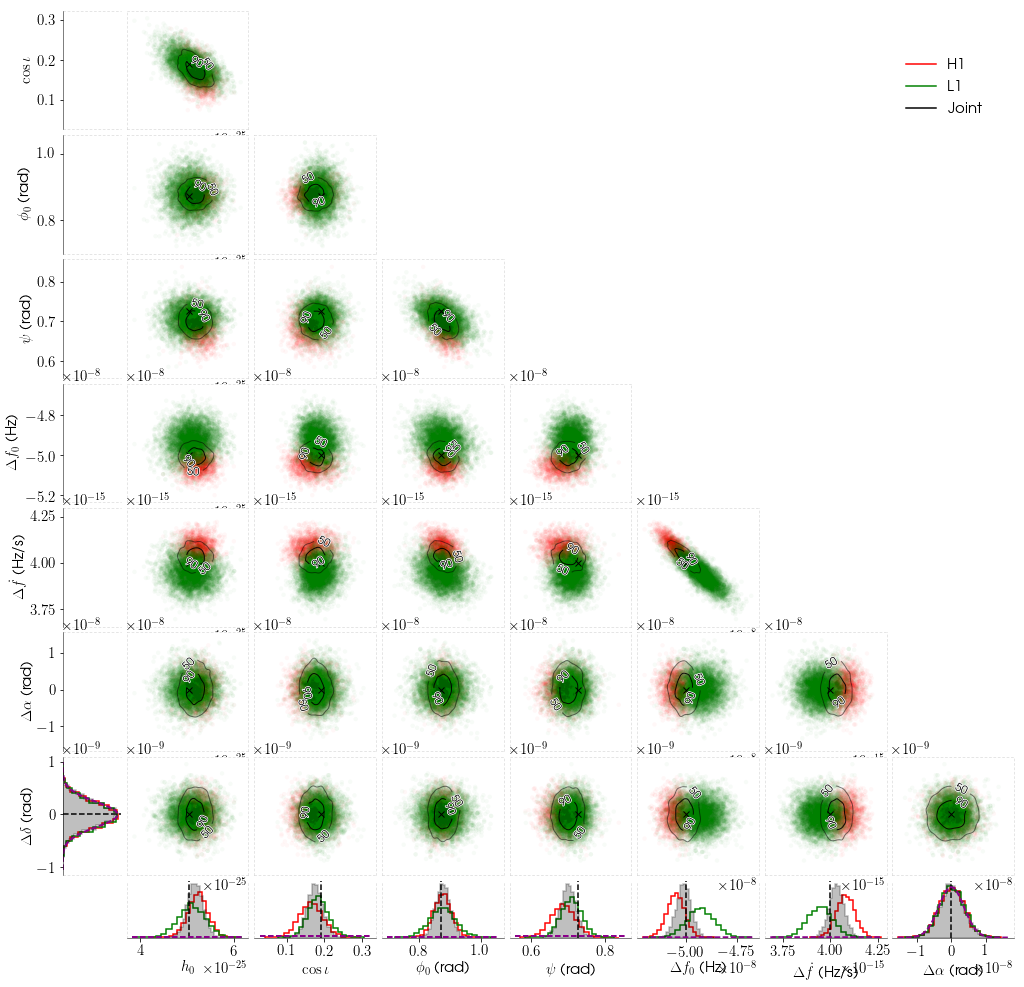

In [9]:
class fermidirac:
    def __init__(self, sigma, mu):
        self.sigma = sigma
        self.mu = mu

    def pdf(self, x):
        return 1./(self.sigma*np.log(1.+np.exp(self.mu/self.sigma))*(1.+np.exp((x-self.mu)/self.sigma)))

priors = {}
priors[ps['H0']] = fermidirac(1.e-24, 1e-24*9.1625)
priors[ps['COSIOTA']] = stats.uniform(-1., 2.)
priors[ps['PHI0']] = stats.uniform(0., np.pi)
priors[ps['PSI']] = stats.uniform(0., np.pi/2.)
priors[ps['F0']] = stats.norm(0., 5e-8)
priors[ps['RA']] = stats.norm(0., 2.*np.pi*5e-5/(24.*60.*60.))
priors[ps['DEC']] = stats.norm(0., 2.*np.pi*5e-5/(360.*60.*60.))
priors[ps['F1']] = stats.norm(0., 5e-15)

histops = {'histtype': 'step', 'color': 'r', 'edgecolor': 'r', 'linewidth': 1.5, 'alpha': 1.0}

#limits = [(None, None), (-1., 1.), (0., np.pi), (0., np.pi/2.), (None, None), (None, None), (None, None), (None, None)]

spp = sc(H1samps, bins=20, ratio=2, labels=ps.values(), datatitle='H1', showlims='both', hist_kwargs=histops,
         showcontours=False, showpoints=True, scatter_kwargs={'alpha': 0.03}, limits=limits,
         thinpoints=4)

histops = {'histtype': 'step', 'color': 'g', 'edgecolor': 'g', 'linewidth': 1.5, 'alpha': 1.0}
spp.add_data(L1samps, hist_kwargs=histops, datatitle='L1', scatter_kwargs={'alpha': 0.03}, showcontours=False,
             limits=limits)

histops = {'histtype': 'stepfilled', 'color': 'k', 'edgecolor': 'k', 'linewidth': 1.5, 'alpha': 0.25}
contourops = {'colors': 'black'}
spp.add_data(Jointsamps, hist_kwargs=histops, datatitle='Joint', scatter_kwargs={'alpha': 0.03}, showcontours=True,
             limits=None, contour_limits=limits, contour_kwargs=contourops, truths=truths, showpoints=False,
             truths_kwargs={'color': 'k', 'linestyle': '--'})

# plot priors
for i, lab in enumerate(ps.values()):
    ax = spp.get_axis(lab)
    
    if i < len(ps.values())-1:
        lims = ax.get_xlim()
    else:
        lims = ax.get_ylim()

    pvals = np.linspace(lims[0], lims[1], 100)
    pdf = priors[lab].pdf(pvals)

    if i < len(ps.values())-1:
        ax.plot(pvals, pdf, color='darkmagenta', linestyle='--', lw=2)
    else:
        ax.plot(pdf, pvals, color='darkmagenta', linestyle='--', lw=2)

In [10]:
import subprocess as sp

spp.savefig('s6sw_inj.pdf')
spp.fig.savefig('s6sw_inj.png', dpi=300)

p = sp.Popen('pdftops -eps %s' % 's6sw_inj.pdf', shell=True)
p.communicate()

caption = r"""\label{fig:s6sw_inj}
Marginalised posterior plots for the recovered parameters of a simulated signal injected into data from the S6
science run: LIGO H1 (red) and L1 (green), and a joint detector analysis (grey). The location of the simulated
signal parameters are marked with a vertical black dash line or black cross. The priors used for each
parameter are shown as the dark magenta dashed lines.
"""

fp = open('caption.tex', 'w')
fp.write(caption)
fp.close()